## Imports

In [41]:
import gymnasium as gym
import gym_donkeycar

import os
from ruamel.yaml import YAML
import numpy as np
from matplotlib import pyplot as plt
import ipywidgets as widgets
from ipywidgets import HBox, VBox
from IPython.display import display
from tqdm import tqdm

from PIL import Image
import imageio

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import distributions as dist
from torch.distributions import Normal, Categorical

import torchvision
from torchvision import transforms

from tensorboard import notebook
from torch.utils.tensorboard import SummaryWriter
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

# suppress warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ["IMAGEIO_IGNORE_WARNINGS"] = "True"

from networks.utils import to_np, load_config, save_image_and_reconstruction

# custom classes and functions
from networks.blocks import ConvBlock, CategoricalStraightThrough
from networks.rssm import RSSM
from networks.mlp import MLP
from networks.categorical_vae import CategoricalVAE
from networks.actor_critic import ContinuousActorCritic
from preprocessing import grayscale_transform as transform

###

import stable_baselines3 as sb3
from stable_baselines3 import SAC, PPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.results_plotter import load_results, ts2xy

import gym.spaces as gym_spaces
import gymnasium as gym # overwrite OpenAI gym
from gymnasium import spaces
from gymnasium.spaces import Box
from stable_baselines3.common.vec_env import DummyVecEnv
from gym_donkeycar.envs.donkey_env import DonkeyEnv
from stable_baselines3.common import env_checker

###

torch.cuda.empty_cache()
%matplotlib inline

## Load the config

In [3]:
config = load_config()

for key in config:
    locals()[key] = config[key]

print(config)

{'device': device(type='cuda', index=0), 'A': 3, 'Z': 1024, 'debug': False, 'logdir': 'logs/', 'seed': 0, 'size': [128, 128], 'grayscale': True, 'toy_env': True, 'n_episodes': 5000, 'max_episode_steps': 100, 'env_id': 'donkey-minimonaco-track-v0', 'max_grad_norm': 100, 'batch_size': 8, 'H': 512, 'num_categoricals': 32, 'num_classes': 32, 'mlp_n_layers': 3, 'mlp_hidden_dims': 256, 'action_clip': 1}


## Create the environment

In [ ]:
sim_config = {
    "exe_path" : "/home/till/Desktop/Thesis/donkeycar_sim/DonkeySimLinux/donkey_sim.x86_64",
    "port" : 9091
}
env = gym.make(
    "GymV21Environment-v0",
    env_id=env_id,
    max_episode_steps=1000,
    make_kwargs={
        "conf": sim_config
    })

## Create the agent

In [ ]:
agent = SAC(
    "CnnPolicy", 
    env,
    buffer_size=20_000,
    verbose=1, 
    tensorboard_log="logs/")

## Train the agent

In [ ]:
agent.learn(total_timesteps=30_000)

In [ ]:
# agent = SAC(
#     "CnnPolicy", 
#     env,
#     buffer_size=20_000,
#     verbose=1, 
#     tensorboard_log="logs/")
# 
# eval_callback = EvalCallback(
#     env, 
#     best_model_save_path='weights/', 
#     log_path='logs/', 
#     eval_freq=500,
#     n_eval_episodes=1)
#
# agent.learn(total_timesteps=30_000, callback=eval_callback)

## Plot the results

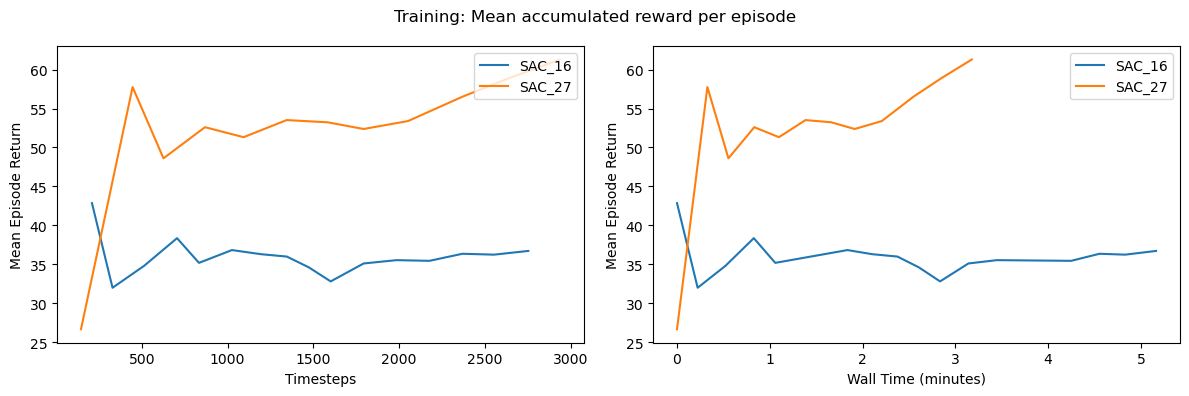

In [52]:
files = {
    "SAC_16": "logs/SAC_16/events.out.tfevents.1684523051.z.25533.2",
    "SAC_27": "logs/SAC_27/events.out.tfevents.1684525093.z.31751.0",
}

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle("Training: Mean accumulated reward per episode", fontsize=12)

""" Steps on x-axis plot """

for key, log_file in files.items():
    event_acc = EventAccumulator(log_file)
    event_acc.Reload()

    steps = []
    rewards = []

    for event in event_acc.Scalars("rollout/ep_rew_mean"):
        steps.append(event.step)
        rewards.append(event.value)
        
    axs[0].plot(steps, rewards, label=key)

axs[0].set_xlabel('Timesteps')
axs[0].set_ylabel('Mean Episode Return')
axs[0].legend(loc="upper right")

""" wall time on x-axis plot """

for key, log_file in files.items():
    event_acc = EventAccumulator(log_file)
    event_acc.Reload()

    wtimes = []
    rewards = []

    for event in event_acc.Scalars("rollout/ep_rew_mean"):
        wtimes.append(event.wall_time)
        rewards.append(event.value)

    # Subtract the first wtime to start at 0 
    # and convert it to minutes
    wtimes = np.array(wtimes) - wtimes[0]
    wtimes /= 60

    axs[1].plot(wtimes, rewards, label=key)

axs[1].set_xlabel('Wall Time (minutes)')
axs[1].set_ylabel('Mean Episode Return')
axs[1].legend(loc="upper right")

plt.tight_layout()
plt.show()